In [1]:
import modin.pandas as pd; import ray; ray.init()
import numpy as np
from sklearn.model_selection import train_test_split
import chess

PATH = 'data/chessData.csv'

In [2]:
df = pd.read_csv(PATH, encoding="utf-8")
# 1 million datapoints. Preprocess to remove "mate in X" evaluations with '#' character. All values between -2k and 2k centipawns. No 0-evaluation.
df['Evaluation'] = df['Evaluation'].apply(pd.to_numeric, errors='coerce')
df = df[(-2000 <= df['Evaluation']) & (df['Evaluation'] <= 2000) & (df['Evaluation'] != 0)].dropna()[:1000000]
x = df['FEN']
y = df['Evaluation']

2023-05-20 21:11:26,169	WARNING __init__.py:183 -- DeprecationWarning: `ray.worker.global_worker` is a private attribute and access will be removed in a future Ray version.
This function is deprecated and will be removed by Ray 2.4. Please use Runtime Environments https://docs.ray.io/en/releases-2.4.0/ray-core/handling-dependencies.html to manage dependencies in workers.


Text(0.5, 0, 'Evaluation Score (Centipawns)')

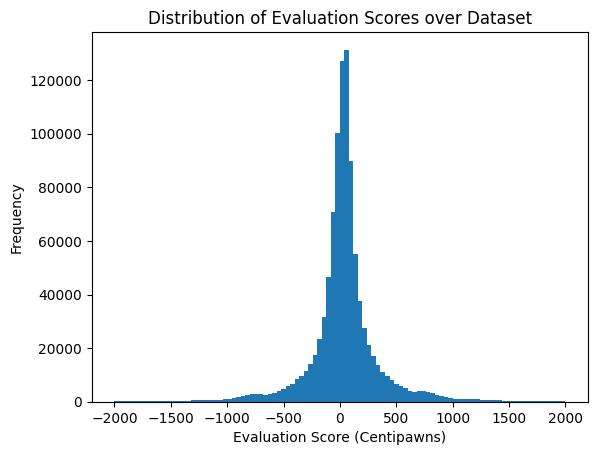

In [3]:
fig = y.plot.hist(bins=100)
fig.set_title('Distribution of Evaluation Scores over Dataset')
fig.set_xlabel('Evaluation Score (Centipawns)')

In [4]:
### 80/10/10 train/val/test split
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.2, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=1)
print('Train/Validation/Test Splits: ' , y_train.shape[0], y_val.shape[0], y_test.shape[0])

Train/Validation/Test Splits:  800000 100000 100000


In [5]:
"""
Credits to @shailesh for portions of this code.
https://github.com/ShaileshSridhar2403/neuralStockfish
"""
pieces = (chess.PAWN,chess.KNIGHT,chess.BISHOP,chess.ROOK,chess.QUEEN,chess.KING)
colours = (chess.WHITE,chess.BLACK)

def fenToVec(fen):
	"""
	Input: 
	FEN string.
	
	Output: 768-vector. Each of the 12 sets (where each set is one of the unique pieces) 
	of 64 elements (where each element is a square) is a one-hot encoding of whether the
	piece is on the square. 12 * 64 = 768.
	"""
	posFen = fen.split()[0]
	board = chess.BaseBoard(posFen)
	l = []
	
	for colour in colours:
		for piece in pieces:
			v = np.zeros(64)
			for i in board.pieces(piece,colour):
				v[i] = 1
			l.append(v)
	l = np.concatenate(l)
	return l


def vecToFen(vec, turn=1):
	"""
	Reverses above function.
	"""
	vecList = np.split(vec,12)
	whiteList = vecList[:6]
	blackList = vecList[6:]
	board = chess.BaseBoard()
	board.clear_board()
	for pieceType in range(len(whiteList)):
		pieceArr = whiteList[pieceType]
		for ind in range(len(pieceArr)):
			if pieceArr[ind]:
				board.set_piece_at(ind ,chess.Piece(pieces[pieceType],chess.WHITE))
				
	for pieceType in range(len(blackList)):
		pieceArr = blackList[pieceType]
		for ind in range(len(pieceArr)):
			if pieceArr[ind]:
				board.set_piece_at(ind ,chess.Piece(pieces[pieceType],chess.BLACK))
	
	return board.board_fen() + (' w' if turn == 1 else ' b')

In [6]:
def isWhiteTurn(fen):
    """ 
    Returns whether it is white's turn, given fen string.
    """
    return 1 if (fen.split()[1] == 'w') else -1

In [7]:
class BaselineModel:
    def __init__(self):
        # Value of pieces in centipawns.
        self.values = {chess.PAWN:100, chess.KNIGHT:300, chess.BISHOP:300, chess.ROOK:500, chess.QUEEN:900, chess.KING:0}

    def predict(self, x):
        board = chess.BaseBoard(x.split()[0])
        return sum((1 if piece.color == chess.WHITE else -1) * self.values[piece.piece_type] for piece in board.piece_map().values())

In [8]:
### Testing Above Functions
baseline = BaselineModel()

x = baseline.predict('8/8/8/4p1K1/2k1P3/8/8/8 b - - 0 1')
print(x, isWhiteTurn('8/8/8/4p1K1/2k1P3/8/8/8 b - - 0 1')) # 0 False

x = baseline.predict('2k5/5n2/8/8/8/8/1R5R/3K4 w - - 0 1')
print(x, isWhiteTurn('2k5/5n2/8/8/8/8/1R5R/3K4 w - - 0 1')) # 700 True

0 False
700 True


In [9]:
def eval(y, y_pred):
    """
    Returns MSE of evaluation scores and accuracy of sign of evaluation 
    scores (which indicate winning player).
    """
    mse = np.mean((y - y_pred)**2)
    accuracy = np.mean(np.sign(y) == np.sign(y_pred))
    return mse, accuracy

In [10]:
### Baseline Test
baseline = BaselineModel()

y_pred = x_train.apply(baseline.predict)
mse, accuracy = eval(y_train, y_pred)
print(f'Baseline Train Error: {mse}.')
print(f'Baseline Train Accuracy: {accuracy}.')

y_pred = x_val.apply(baseline.predict)
mse, accuracy = eval(y_val, y_pred)
print(f'Baseline Validation Error: {mse}.')
print(f'Baseline Validation Accuracy: {accuracy}.')

To request implementation, send an email to feature_requests@modin.org.


Baseline Train Error: 94173.24661.
Baseline Train Accuracy: 0.34758375.
Baseline Validation Error: 95203.80661.
Baseline Validation Accuracy: 0.34994.
